# Benchmark Analysis - H5

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M'

In [5]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [6]:
plot_save_dir = './plots/h5'

## Utils 

In [7]:
def get_path(*entries):
    return os.path.join(*entries)

In [8]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [9]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"))
    plt.show()

In [10]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [11]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [12]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [13]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [14]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [15]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(f'{root_dir}/{compiler_location}/DEFAULT/{bench_name}_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    print(seq_base)

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H5
> Parallel stl backends use special parallelism techniques for linear algorithms, which have no clear reference
> implementation, leading to significant differences in terms of performance and their strong scaling properties.


## `b5_1_find_std::vector<int>_first_entry_par`

In [16]:
benchmark_name = "b5_1_find_std::vector<int>_first_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_first_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [17]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_first_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_first_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,6287.56,4,48071.3
1,9496.17,8,41086.9
2,14243.50,16,40176.8
3,19957.10,32,44297.9
4,24284.50,64,44470.5
5,26751.00,128,44488.2
6,28129.20,256,43556.9
7,30339.50,512,42754.5
8,33302.10,1024,43804.6
9,36765.10,2048,41914.7


### Strong Scaling - `b5_1_find_std::vector<int>_first_entry`
 
2^26 fixed input size with threads 1-64

In [18]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_first_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_first_entry_strong_scaling_merged

0                                               name  real_time  cpu_time  \
0  GCC_TBB_b5_1_find_std::vector<int>_first_entry...    265.213    266.92   

0 time_unit         n   median   stddev  Compiler  
0        ns  67108864  265.213  1.00236  GCC(TBB)  
0                                               name  real_time  cpu_time  \
0  NVHPC_Multicore_b5_1_find_std::vector<int>_fir...    262.054    263.89   

0 time_unit         n   median    stddev  Compiler  
0        ns  67108864  262.054  0.117408  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,0.002596,0.000230
1,2,0.004688,0.000451
2,4,0.006119,0.000859
3,8,0.006033,0.001495
4,16,0.006036,0.002223
5,32,0.006578,0.002774
6,64,0.006107,0.002884


In [19]:
## efficiency graph

b5_1_find_std_vector_int_first_entry_efficiency = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_first_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_first_entry_efficiency['threads']



b5_1_find_std_vector_int_first_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.002596,0.000230
1,2,0.002344,0.000225
2,4,0.001530,0.000215
3,8,0.000754,0.000187
4,16,0.000377,0.000139
5,32,0.000206,0.000087
6,64,0.000095,0.000045


### Plots

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_6364/1785937751.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


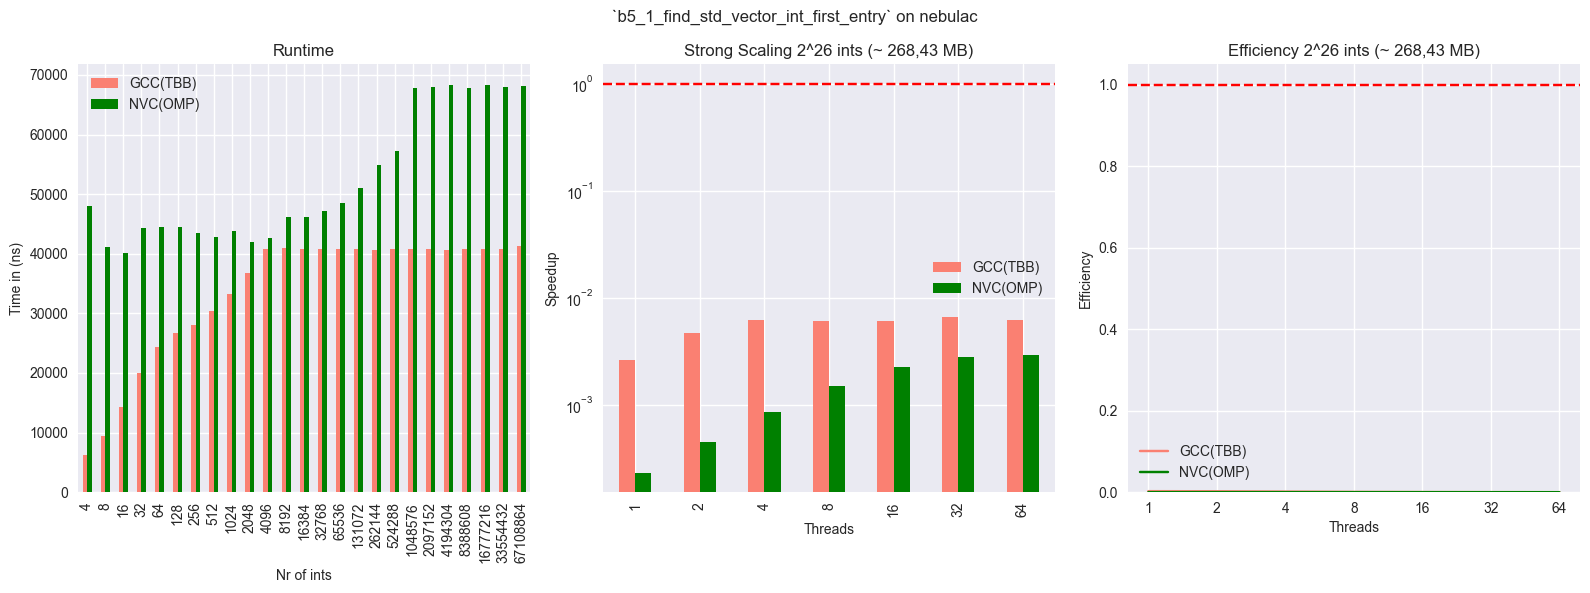

In [20]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_first_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b5_1_find_std_vector_int_first_entry_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b5_1_find_std_vector_int_first_entry_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle("`b5_1_find_std_vector_int_first_entry` on nebulac")

fig.tight_layout()

plot("`b5_1_find_std_vector_int_first_entry` nebulac")

## `b5_1_find_std::vector<int>_last_entry_par`

In [21]:
benchmark_name = "b5_1_find_std::vector<int>_last_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_last_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [22]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_last_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_last_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,5434.78,4,63736.6
1,9440.90,8,42887.6
2,14330.10,16,40284.3
3,19217.40,32,39873.5
4,23512.90,64,40228.0
5,26279.00,128,40367.9
6,28127.90,256,40201.8
7,31434.00,512,40133.8
8,34039.30,1024,40238.7
9,38086.60,2048,41838.7


### Strong Scaling - `b5_1_find_std::vector<int>_last_entry`
 
2^26 fixed input size with threads 1-64

In [23]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_last_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_last_entry_strong_scaling_merged

0                                               name   real_time    cpu_time  \
0  GCC_TBB_b5_1_find_std::vector<int>_last_entry_seq  21674200.0  21675800.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  21674200.0  5677.97  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_1_find_std::vector<int>_las...  22561500.0  22564100.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  22561500.0  5363.19  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,1.002702,0.280989
1,2,1.927127,0.551993
2,4,2.081556,1.029886
3,8,2.471025,1.011726
4,16,2.221844,1.224365
5,32,2.266026,1.071535
6,64,2.113257,0.795391


In [24]:
## efficiency graph

b5_1_find_std_vector_int_last_entry_efficiency = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_last_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_last_entry_efficiency['threads']



b5_1_find_std_vector_int_last_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.002702,0.280989
1,2,0.963563,0.275997
2,4,0.520389,0.257471
3,8,0.308878,0.126466
4,16,0.138865,0.076523
5,32,0.070813,0.033485
6,64,0.033020,0.012428


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_6364/3271728666.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


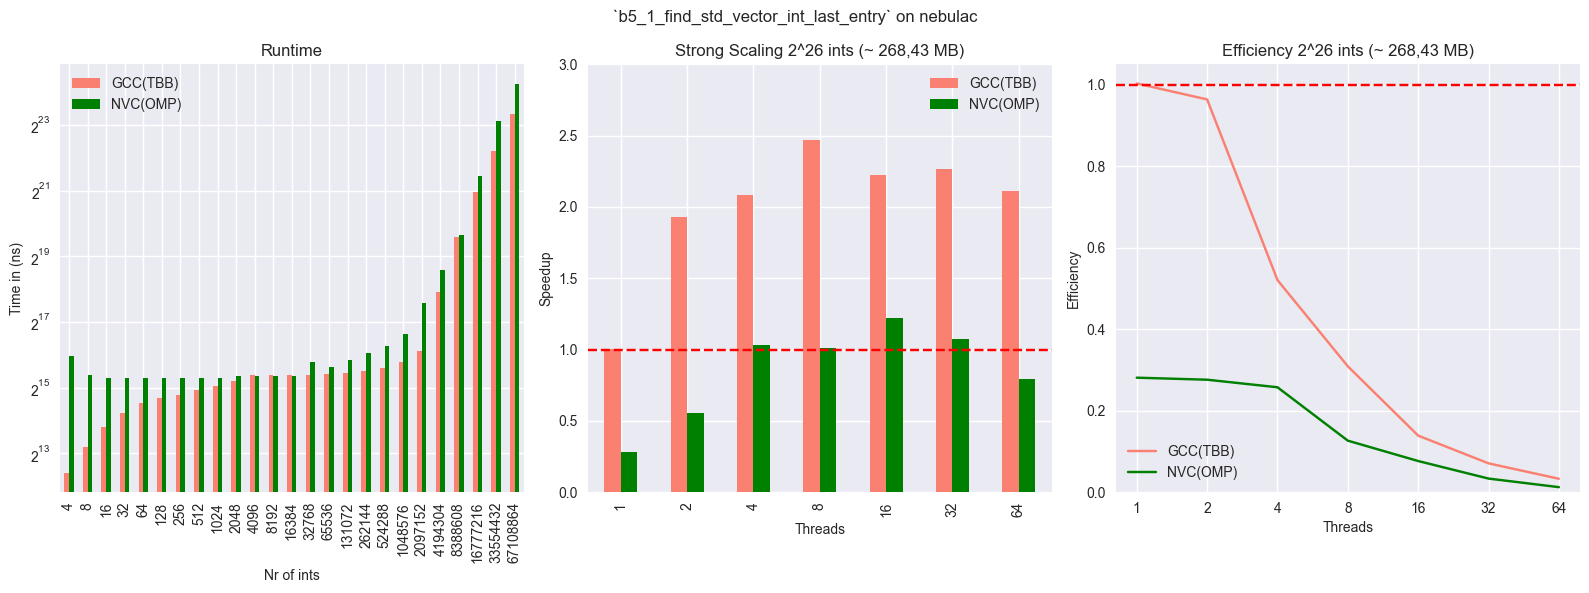

In [25]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_last_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_last_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_last_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle("`b5_1_find_std_vector_int_last_entry` on nebulac")

fig.tight_layout()

plot("`b5_1_find_std_vector_int_last_entry` nebulac")

## `b5_1_find_std::vector<int>_non_existing_entry_par`

In [26]:
benchmark_name = "b5_1_find_std::vector<int>_non_existing_entry"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_1_find_std::vector<int>_non_existing_entry_par`

Check how the runtime without constraining the threads develops with increasing input size

In [27]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_1_find_std_vector_int_non_existing_entry_time_merged = pd.merge(*data, on='n')

b5_1_find_std_vector_int_non_existing_entry_time_merged

,GCC(TBB),n,NVC(OMP)
0,5929.29,4,50673.7
1,10494.80,8,41583.1
2,15342.20,16,43096.3
3,20137.90,32,40757.6
4,23875.90,64,43429.4
5,28318.10,128,46585.4
6,27313.50,256,45180.2
7,32229.10,512,46082.6
8,34641.90,1024,42807.8
9,37913.80,2048,41970.1


### Strong Scaling - `b5_1_find_std::vector<int>_non_existing_entry`
 
2^26 fixed input size with threads 1-64

In [28]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged = pd.merge(*data, on='threads')

b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged

0                                               name   real_time    cpu_time  \
0  GCC_TBB_b5_1_find_std::vector<int>_non_existin...  20453500.0  20455400.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  20453500.0  55.4727  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_1_find_std::vector<int>_non...  20934000.0  20936500.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  20934000.0  29903.8  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,1.059981,0.286238
1,2,1.941942,0.559275
2,4,2.542545,0.862923
3,8,2.550792,1.273575
4,16,2.160281,1.267299
5,32,2.112583,1.091706
6,64,1.927085,0.989740


In [29]:
## efficiency graph

b5_1_find_std_vector_int_non_existing_entry_efficiency = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] = b5_1_find_std_vector_int_non_existing_entry_efficiency[f'{compiler_name}'] / b5_1_find_std_vector_int_non_existing_entry_efficiency['threads']



b5_1_find_std_vector_int_non_existing_entry_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.059981,0.286238
1,2,0.970971,0.279638
2,4,0.635636,0.215731
3,8,0.318849,0.159197
4,16,0.135018,0.079206
5,32,0.066018,0.034116
6,64,0.030111,0.015465


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_6364/2019396929.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


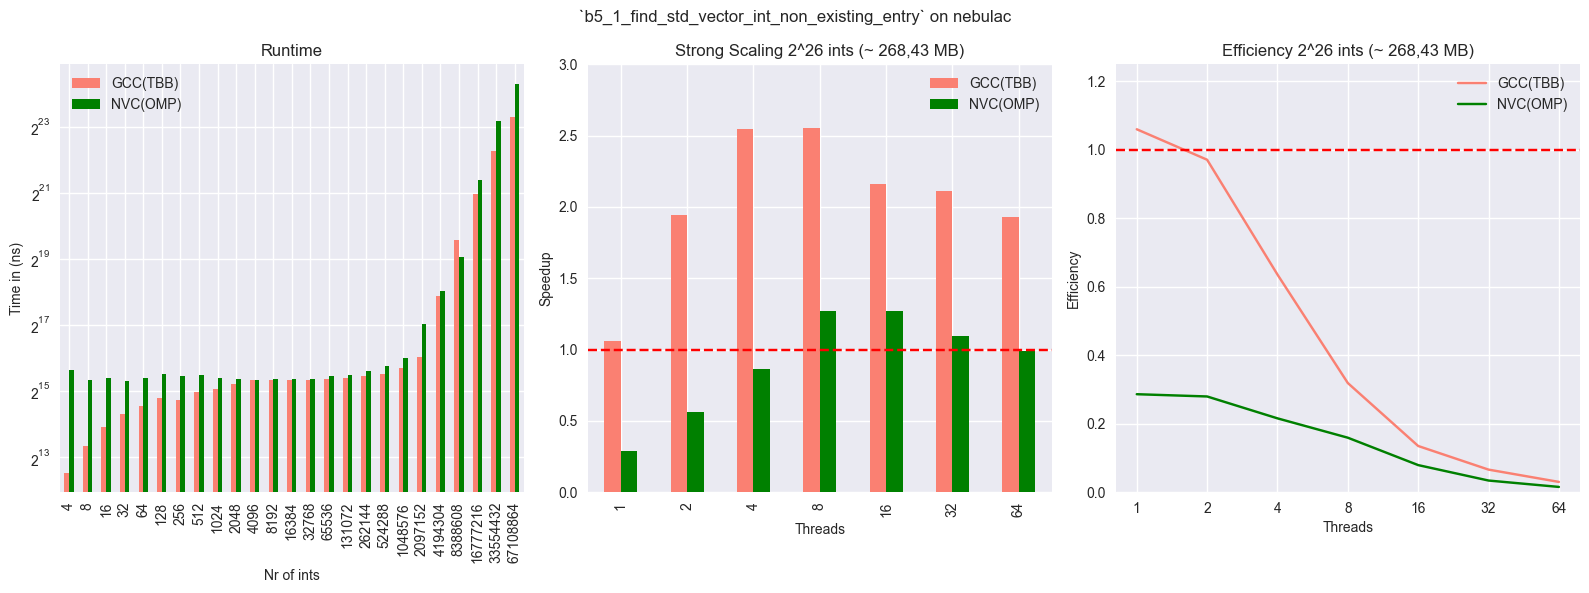

In [30]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_1_find_std_vector_int_non_existing_entry_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_1_find_std_vector_int_non_existing_entry_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_1_find_std_vector_int_non_existing_entry_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle("`b5_1_find_std_vector_int_non_existing_entry` on nebulac")

fig.tight_layout()

plot("`b5_1_find_std_vector_int_non_existing_entry` nebulac")

## `b5_2_partition_par`

In [31]:
benchmark_name = "b5_2_partition"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_2_partition_par`

Check how the runtime without constraining the threads develops with increasing input size

In [32]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_2_partition_time_merged = pd.merge(*data, on='n')

b5_2_partition_time_merged

,GCC(TBB),n,NVC(OMP)
0,7770.46,4,3.495270e+02
1,13202.40,8,4.209830e+02
2,18727.60,16,5.597250e+02
3,23920.00,32,8.378200e+02
4,27941.40,64,1.393300e+03
5,30258.00,128,2.505390e+03
6,37112.90,256,4.728270e+03
7,41358.70,512,9.213890e+03
8,46985.70,1024,1.811280e+04
9,54569.50,2048,3.590050e+04


### Strong Scaling - `b5_2_partition_strong_par`
 
2^26 fixed input size with threads 1-64

In [33]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_2_partition_strong_scaling_merged = pd.merge(*data, on='threads')

b5_2_partition_strong_scaling_merged

0                        name     real_time      cpu_time time_unit         n  \
0  GCC_TBB_b5_2_partition_seq  1.284220e+09  1.284190e+09        ns  67108864   

0        median    stddev  Compiler  
0  1.284220e+09  626645.0  GCC(TBB)  
0                                name     real_time      cpu_time time_unit  \
0  NVHPC_Multicore_b5_2_partition_seq  1.190710e+09  1.190680e+09        ns   

0         n        median     stddev  Compiler  
0  67108864  1.190710e+09  1689100.0  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,0.996849,1.014631
1,2,1.997272,1.014778
2,4,3.983152,1.015488
3,8,7.093962,1.015185
4,16,15.542452,1.015522
5,32,28.223437,1.015375
6,64,53.345352,1.014372


In [34]:
## efficiency graph

b5_2_partition_efficiency = b5_2_partition_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_2_partition_efficiency[f'{compiler_name}'] = b5_2_partition_efficiency[f'{compiler_name}'] / b5_2_partition_efficiency['threads']



b5_2_partition_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.996849,1.014631
1,2,0.998636,0.507389
2,4,0.995788,0.253872
3,8,0.886745,0.126898
4,16,0.971403,0.063470
5,32,0.881982,0.031730
6,64,0.833521,0.015850


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_6364/3104984362.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


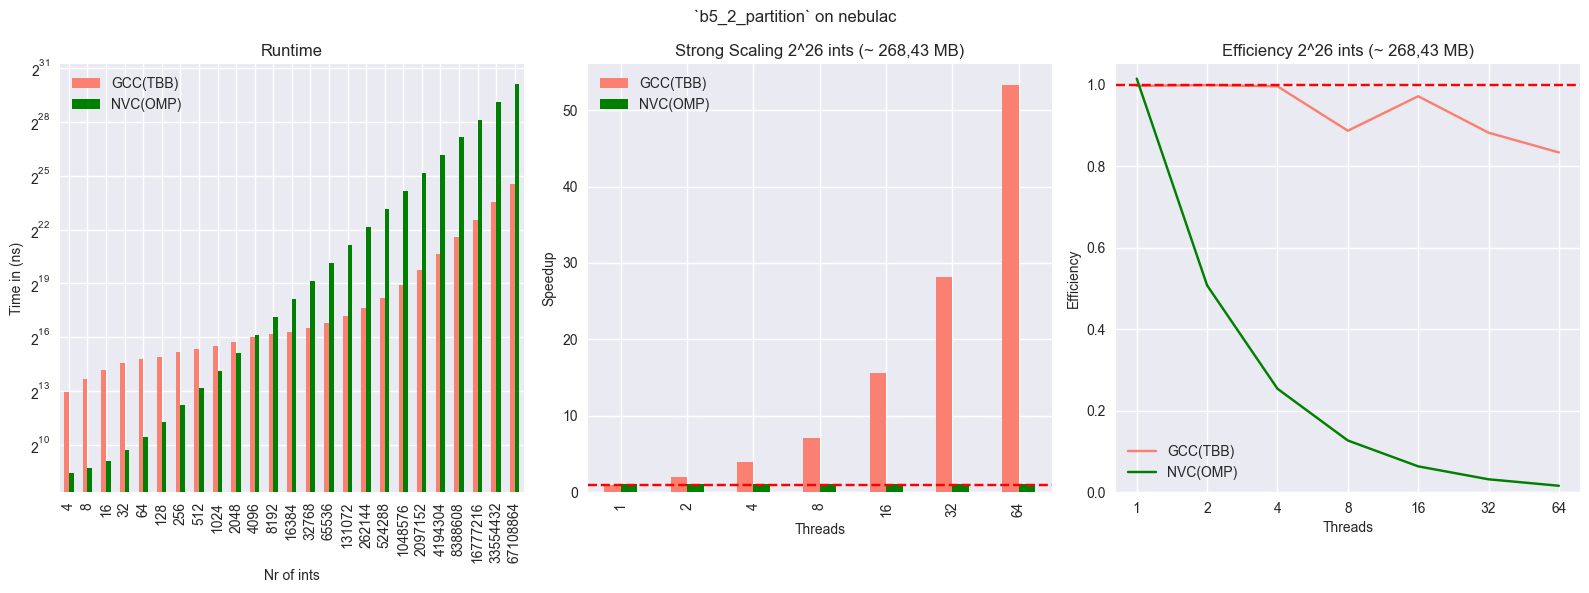

In [35]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_2_partition_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_2_partition_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_2_partition_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_2_partition` on nebulac")

fig.tight_layout()

plot("`b5_2_partition` nebulac")

## `b5_3_unique_copy_default_par`

In [36]:
benchmark_name = "b5_3_unique_copy_default"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_3_unique_copy_default_par`

Check how the runtime without constraining the threads develops with increasing input size

In [37]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_3_unique_copy_default_time_merged = pd.merge(*data, on='n')

b5_3_unique_copy_default_time_merged

,GCC(TBB),n,NVC(OMP)
0,23077.9,4,23356.4
1,45464.9,8,20779.6
2,61706.2,16,23451.7
3,72988.1,32,25395.8
4,85966.0,64,25408.7
5,93105.7,128,24298.1
6,98651.7,256,24802.9
7,96720.8,512,27071.6
8,90429.2,1024,25644.1
9,91809.8,2048,28405.3


### Strong Scaling - `b5_3_unique_copy_default_strong_par`
 
2^26 fixed input size with threads 1-64

In [38]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_3_unique_copy_default_strong_scaling_merged = pd.merge(*data, on='threads')

b5_3_unique_copy_default_strong_scaling_merged

0                                  name   real_time    cpu_time time_unit  \
0  GCC_TBB_b5_3_unique_copy_default_seq  46920800.0  46922100.0        ns   

0         n      median   stddev  Compiler  
0  67108864  46920800.0  51798.8  GCC(TBB)  
0                                          name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_3_unique_copy_default_seq  24304800.0  24306600.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  24304800.0  9922.86  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,0.626843,0.060050
1,2,1.138189,0.102867
2,4,1.639258,0.161248
3,8,2.574756,0.192924
4,16,2.671951,0.245306
5,32,2.667000,0.257630
6,64,2.502403,0.239425


In [39]:
## efficiency graph

b5_3_unique_copy_default_efficiency = b5_3_unique_copy_default_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_3_unique_copy_default_efficiency[f'{compiler_name}'] = b5_3_unique_copy_default_efficiency[f'{compiler_name}'] / b5_3_unique_copy_default_efficiency['threads']



b5_3_unique_copy_default_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.626843,0.060050
1,2,0.569094,0.051434
2,4,0.409814,0.040312
3,8,0.321844,0.024116
4,16,0.166997,0.015332
5,32,0.083344,0.008051
6,64,0.039100,0.003741


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_6364/3892902762.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


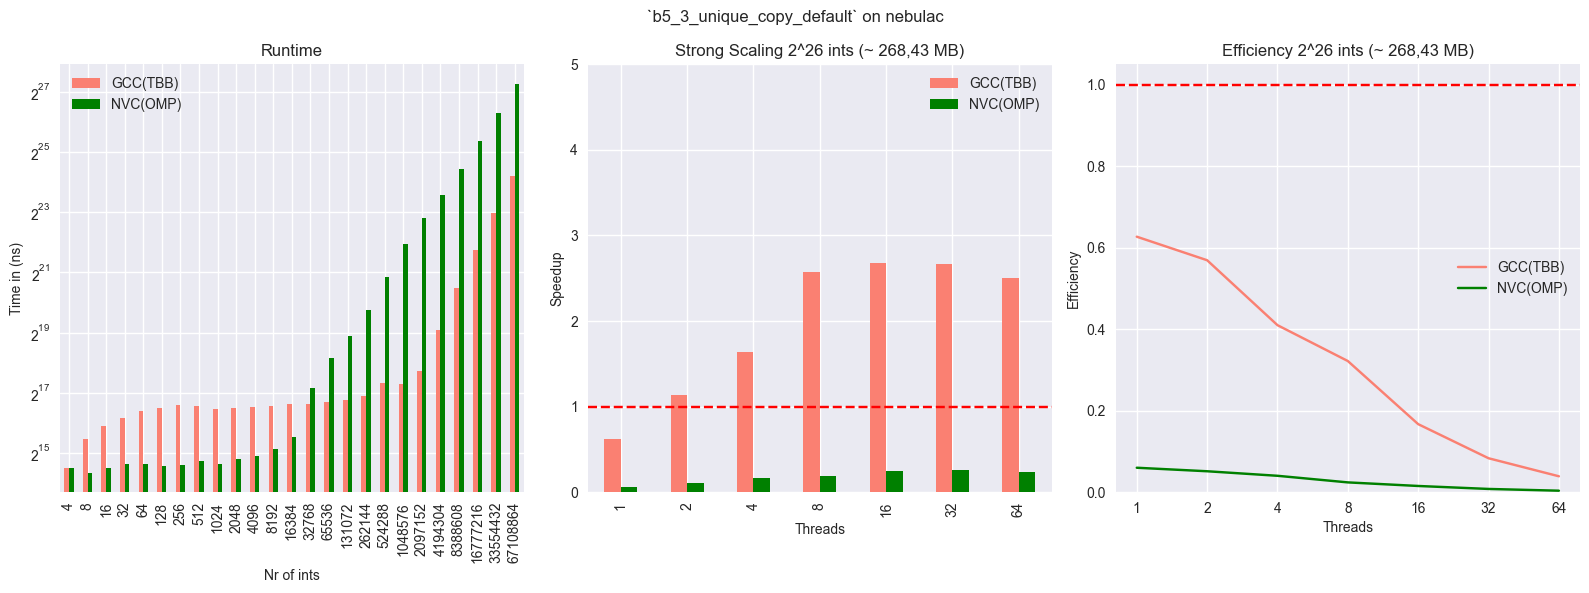

In [40]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_3_unique_copy_default_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_3_unique_copy_default_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,5)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_3_unique_copy_default_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_3_unique_copy_default` on nebulac")

fig.tight_layout()

plot("`b5_3_unique_copy_default` nebulac")

## `b5_4_minmax_element_all_equal_par`

In [41]:
benchmark_name = "b5_4_minmax_element_all_equal"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_all_equal_par`

Check how the runtime without constraining the threads develops with increasing input size

In [42]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_all_equal_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_all_equal_time_merged

,GCC(TBB),n,NVC(OMP)
0,6032.39,4,108039.0
1,10922.40,8,52753.2
2,17130.80,16,46703.7
3,22661.70,32,48569.2
4,27297.20,64,48722.4
5,29647.50,128,49699.9
6,33055.00,256,49456.2
7,37189.50,512,50776.2
8,41619.20,1024,49951.8
9,46316.20,2048,50240.1


### Strong Scaling - `b5_4_minmax_element_all_equal_strong_par`
 
2^26 fixed input size with threads 1-64

In [43]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_all_equal_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_all_equal_strong_scaling_merged

0                                       name   real_time    cpu_time  \
0  GCC_TBB_b5_4_minmax_element_all_equal_seq  78879100.0  78880400.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78879100.0  15793.4  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_4_minmax_element_all_equal_seq  78829700.0  78828500.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78829700.0  32810.2  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,2.171937,0.184919
1,2,4.043423,0.369615
2,4,7.960912,0.730351
3,8,8.550191,1.411815
4,16,7.830590,2.656667
5,32,8.090479,3.951661
6,64,7.329205,4.378260


In [44]:
## efficiency graph

b5_4_minmax_element_all_equal_efficiency = b5_4_minmax_element_all_equal_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] = b5_4_minmax_element_all_equal_efficiency[f'{compiler_name}'] / b5_4_minmax_element_all_equal_efficiency['threads']



b5_4_minmax_element_all_equal_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.171937,0.184919
1,2,2.021712,0.184808
2,4,1.990228,0.182588
3,8,1.068774,0.176477
4,16,0.489412,0.166042
5,32,0.252827,0.123489
6,64,0.114519,0.068410


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_6364/3776077154.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


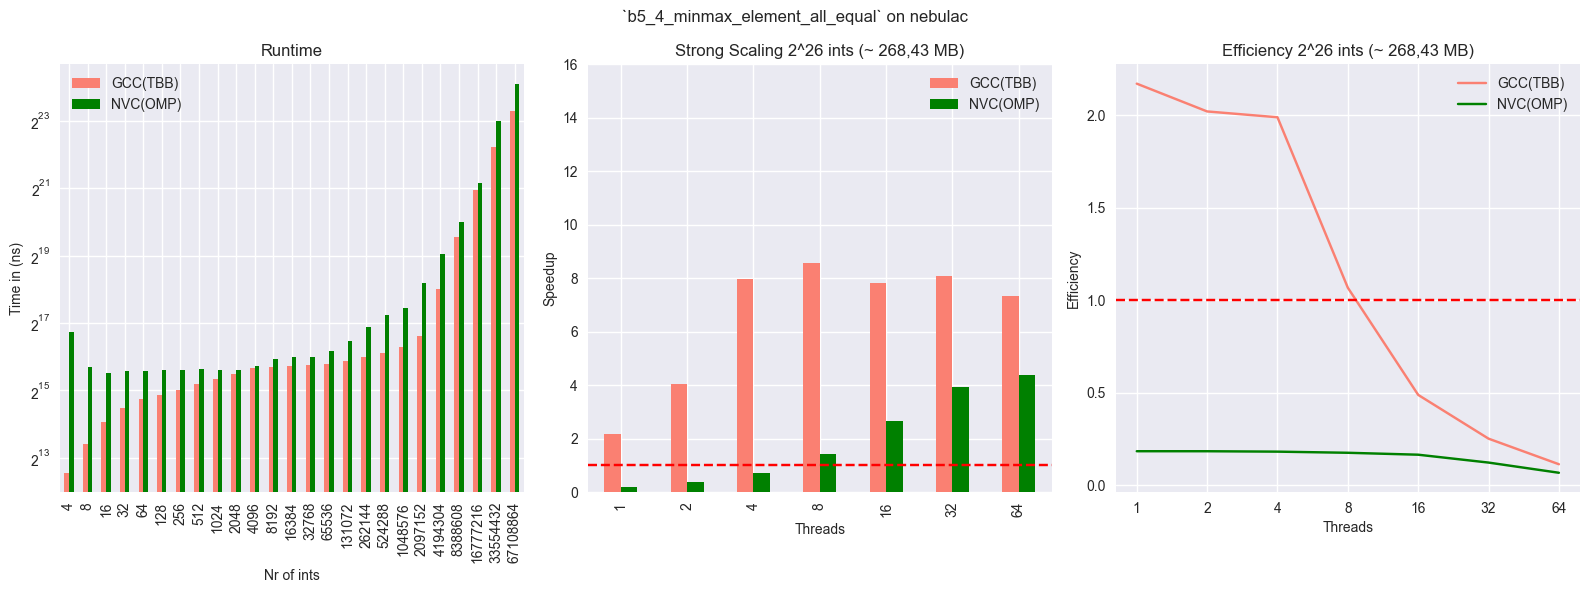

In [45]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_all_equal_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_all_equal_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


ax_2.set_ylim(0,16)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_all_equal_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_4_minmax_element_all_equal` on nebulac")

fig.tight_layout()

plot("`b5_4_minmax_element_all_equal` nebulac")

## `b5_4_minmax_element_increasing_par`

In [46]:
benchmark_name = "b5_4_minmax_element_increasing"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b5_4_minmax_element_increasing_par`

Check how the runtime without constraining the threads develops with increasing input size

In [47]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b5_4_minmax_element_increasing_time_merged = pd.merge(*data, on='n')

b5_4_minmax_element_increasing_time_merged

,GCC(TBB),n,NVC(OMP)
0,5759.47,4,47737.0
1,10249.60,8,47530.6
2,16274.10,16,48538.3
3,21681.60,32,49216.0
4,27361.00,64,48147.7
5,29417.40,128,47869.5
6,31644.40,256,47844.6
7,35744.00,512,49340.8
8,40252.00,1024,50097.2
9,44892.90,2048,48307.2


### Strong Scaling - `b5_4_minmax_element_increasing_strong_par`
 
2^26 fixed input size with threads 1-64

In [48]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b5_4_minmax_element_increasing_strong_scaling_merged = pd.merge(*data, on='threads')

b5_4_minmax_element_increasing_strong_scaling_merged

0                                        name   real_time    cpu_time  \
0  GCC_TBB_b5_4_minmax_element_increasing_seq  78851600.0  78851500.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78851600.0  24931.6  GCC(TBB)  
0                                               name   real_time    cpu_time  \
0  NVHPC_Multicore_b5_4_minmax_element_increasing...  78846800.0  78845900.0   

0 time_unit         n      median   stddev  Compiler  
0        ns  67108864  78846800.0  3688.43  NVC(OMP)  


,threads,GCC(TBB),NVC(OMP)
0,1,2.174095,0.195068
1,2,4.410316,0.390016
2,4,8.353941,0.773448
3,8,8.653818,1.471231
4,16,7.447120,2.947213
5,32,8.368775,3.772917
6,64,7.319237,3.203787


In [49]:
## efficiency graph

b5_4_minmax_element_increasing_efficiency = b5_4_minmax_element_increasing_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] = b5_4_minmax_element_increasing_efficiency[f'{compiler_name}'] / b5_4_minmax_element_increasing_efficiency['threads']



b5_4_minmax_element_increasing_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.174095,0.195068
1,2,2.205158,0.195008
2,4,2.088485,0.193362
3,8,1.081727,0.183904
4,16,0.465445,0.184201
5,32,0.261524,0.117904
6,64,0.114363,0.050059


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_6364/145666751.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


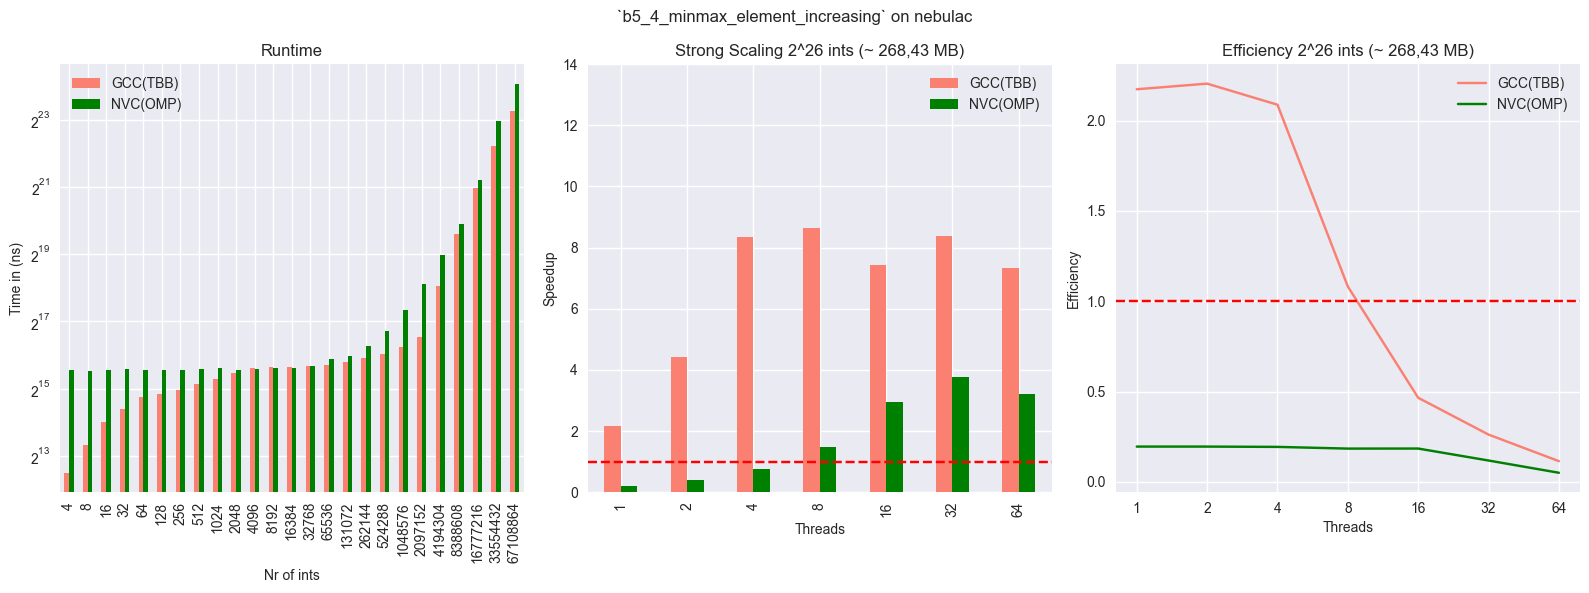

In [50]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b5_4_minmax_element_increasing_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b5_4_minmax_element_increasing_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,14)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b5_4_minmax_element_increasing_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b5_4_minmax_element_increasing` on nebulac")

fig.tight_layout()

plot("`b5_4_minmax_element_increasing` nebulac")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

TODO

In [51]:
# calc pp_metrics


## Findings for H2

### XXX

### General


### GPU Findings


### Hypothesis Findings


